In [2]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing

In [9]:
#f_list = [os.path.join(root,f) for root,dirs,files in os.walk(
#    '../derivatives/') for f in files if 
#          (('me1' in f) & (f.endswith('desc-preproc_bold.nii.gz')))|
#         (('me4' in f ) & (f.endswith('desc-optcom-dewarped_bold.nii.gz')))]

f_list = [os.path.join(root,f) for root,dirs,files in os.walk(
   '../derivatives/fmriprep') for f in files if f.endswith('space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')]
sub_list=['sub-10185', 'sub-10198', 'sub-10203', 'sub-10223', 'sub-10303', 'sub-10318', 'sub-10319', 'sub-10320','sub-10321', 'sub-10363', 'sub-10416', 'sub-12042']
f_list=[f for f in f_list if any(substring in f for substring in sub_list)]
display(f_list)

['../derivatives/fmriprep/sub-12042/func/sub-12042_task-sharedreward_acq-mb1me1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-12042/func/sub-12042_task-sharedreward_acq-mb6me4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-12042/func/sub-12042_task-sharedreward_acq-mb3me1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-12042/func/sub-12042_task-sharedreward_acq-mb1me4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-12042/func/sub-12042_task-sharedreward_acq-mb6me1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-12042/func/sub-12042_task-sharedreward_acq-mb3me4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-10223/func/sub-10223_task-sharedreward_acq-mb3me4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/sub-10223/func/sub-10223_task-sharedreward_

# Making anatomical Masks and getting files

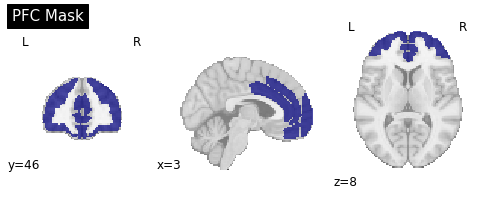

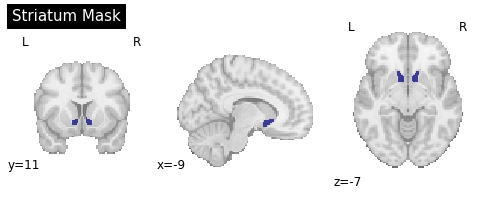

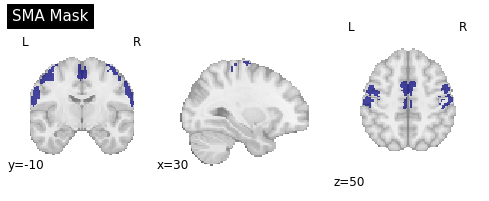

In [10]:
from nilearn import image,datasets,masking,plotting,input_data
#Striatum Mask



HO_sub=datasets.fetch_atlas_harvard_oxford(atlas_name='sub-maxprob-thr25-2mm')

keep = [idx for idx, s in enumerate(HO_sub.labels) if
        'Accumbens' in s]

keepimg_list=[image.math_img("img==%s"%(idx),img=HO_sub.maps) for idx in keep]   

str_regions=image.concat_imgs(np.array(keepimg_list))
str_mask=masking.compute_background_mask(str_regions)
str_mask=NiftiMasker(mask_img=str_mask)

#MPFC mask
HO_cort=datasets.fetch_atlas_harvard_oxford(atlas_name='cort-maxprob-thr50-2mm')
keep = [idx for idx, s in enumerate(HO_cort.labels) if
        'Frontal Medial Cortex'==s or
        'Frontal Pole'==s or
        'Frontal Orbital Cortex'==s or
        'Cingulate Gyrus, anterior division'==s or
        'Paracingulate Gyrus'==s]

keepimg_list=[image.math_img("img==%s"%(idx),img=HO_cort.maps) for idx in keep]                               

cort_regions=image.concat_imgs(np.array(keepimg_list))
cort_mask=masking.compute_background_mask(cort_regions)
cort_mask=NiftiMasker(mask_img=cort_mask)

#SMA mask
HO_cort=datasets.fetch_atlas_harvard_oxford(atlas_name='cort-maxprob-thr50-2mm')
keep = [idx for idx, s in enumerate(HO_cort.labels) if
        'Juxtapositional Lobule Cortex' in s or
        'Precentral Gyrus'==s or
        'Postcentral Gyrus'==s]

keepimg_list=[image.math_img("img==%s"%(idx),img=HO_cort.maps) for idx in keep]                               

SMA_regions=image.concat_imgs(np.array(keepimg_list))
SMA_mask=masking.compute_background_mask(SMA_regions)
SMA_mask=NiftiMasker(mask_img=SMA_mask)

plotting.plot_roi(cort_mask.mask_img,title="PFC Mask", draw_cross=False)
plt.show()
plotting.plot_roi(str_mask.mask_img,title='Striatum Mask',draw_cross=False)
plt.show()
plotting.plot_roi(SMA_mask.mask_img,title='SMA Mask',draw_cross=False)
plt.show()

# TSNR
- Heads up these Graphs are interactive

In [13]:
data=[]
img_list=[]
for img in f_list:
    start = time.time()

    me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
    mb=int(re.search('_acq-mb(.*?)me',img).group(1))
    sub=re.search('func/sub-(.*?)_task',img).group(1)
    print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
    mask = '../derivatives/fmriprep/sub-%s/func/sub-%s_task-sharedreward_acq-mb%sme%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(sub,sub,mb,me)
    
    nifti_masker = NiftiMasker(mask_img=mask)
    x=nifti_masker.fit_transform(img)
    img=nifti_masker.inverse_transform(x)
    end = time.time()
    #print("first maskfit:",end - start)
    #print(img.shape)
    
    
    # calculate mean image for the background
    from nilearn.image import math_img
    tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)
    tsnr_img.to_filename('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me))
    img_list.append([tsnr_img,me,mb,sub])

In [20]:
data = []
for row in img_list:
    tsnr_img = row[0]
    me = row[1]
    mb = row[2]
    sub = row[3]
    y=str_mask.fit_transform(tsnr_img)
    end = time.time()
    print("STR maskfit:",end - start)

    z=cort_mask.fit_transform(tsnr_img)
    end = time.time()
    print("CORT maskfit:",end - start)
    data.append([sub,mb,me,np.mean(np.abs(y.flatten())),
                 np.mean(np.abs(z.flatten()))])

    end = time.time()
    print(end - start)

STR maskfit: 95462.75346851349
CORT maskfit: 95463.03835320473
95463.03911972046
STR maskfit: 95463.27566027641
CORT maskfit: 95463.56899857521
95463.56966781616
STR maskfit: 95463.8615899086
CORT maskfit: 95464.19127821922
95464.19209694862
STR maskfit: 95464.47551941872
CORT maskfit: 95464.78926849365
95464.79035902023
STR maskfit: 95465.07347083092
CORT maskfit: 95465.35568785667
95465.35649204254
STR maskfit: 95465.61098980904
CORT maskfit: 95465.93346524239
95465.93441963196
STR maskfit: 95466.16873693466
CORT maskfit: 95466.46492958069
95466.46558976173
STR maskfit: 95466.75402069092
CORT maskfit: 95467.11834335327
95467.11910438538
STR maskfit: 95467.42934417725
CORT maskfit: 95467.73445677757
95467.7347164154
STR maskfit: 95467.99346351624
CORT maskfit: 95468.33064293861
95468.3314294815
STR maskfit: 95468.55748081207
CORT maskfit: 95468.89964199066
95468.90085506439
STR maskfit: 95469.1682343483
CORT maskfit: 95469.46817278862
95469.46840000153
STR maskfit: 95469.77630877495
C

,sub,MB,ME,Region,TSNR
0,12042,1,1,Striatum,35.013843
1,12042,6,4,Striatum,19.639397
2,12042,3,1,Striatum,30.612680
3,12042,1,4,Striatum,53.346607
4,12042,6,1,Striatum,30.643558


<AxesSubplot:xlabel='MB', ylabel='TSNR'>

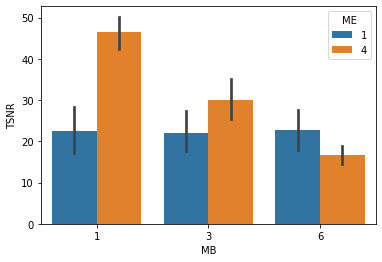

In [21]:

df=pd.DataFrame(data=data,columns=['sub','MB','ME','Striatum','MPFC'])
df.to_csv("TSNRinfo.tsv",sep="\t",index=False)
df=df.melt(id_vars=['sub','MB','ME'],var_name='Region',value_name='TSNR')
display(df.head())
plt_df=df[df['Region']=='Striatum']

sns.barplot(x='MB',y='TSNR',hue='ME',data=plt_df)

In [ ]:
img_list


def collect_tsnr(img):
    start = time.time()

    me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
    mb=int(re.search('_acq-mb(.*?)me',img).group(1))
    sub=re.search('func/sub-(.*?)_task',img).group(1)
    print(sub,mb,me)
    #mask = re.sub("desc-(.*?).nii.gz","desc-brain_mask.nii.gz",img)
    
    nifti_masker = NiftiMasker(mask_strategy='background')
    x=nifti_masker.fit_transform(img)
    img=nifti_masker.inverse_transform(x)
    end = time.time()
    print("first maskfit:",end - start)
    print(img.shape)
    
    
    # calculate mean image for the background
    from nilearn.image import math_img
    tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)
    img_list=[tsnr_img,me,mb,sub]
    y=str_mask.fit_transform(tsnr_img)
    print("STR maskfit:",end - start)
    z=cort_mask.fit_transform(tsnr_img)
    print("CORT maskfit:",end - start)
    data_row=[sub,mb,me,np.mean(np.abs(x.flatten())),
                 np.mean(np.abs(y.flatten())),
                 np.mean(np.abs(z.flatten()))]
    return([img_list,data_row])

    end = time.time()
    print(end - start)

def driver_func(myfunc,input_list):
    THREADS=10
    with multiprocessing.Pool(THREADS) as pool:
        results=pool.map(myfunc,input_list)
    return(results)
data=driver_func(collect_tsnr,f_list)

for img in img_list:
    plotting.plot_stat_map(img[0],
                      title="tsnr for Sub: %s ME: %s MB: %s "%(img[3],img[1],img[2]),
                      vmax=200,draw_cross=False)
    plt.show()


## Plot tsnr Maps

In [ ]:
img=f_list[0]

#nifti_masker = NiftiMasker(mask_strategy='epi')
#x=nifti_masker.fit_transform(img)
#img=nifti_masker.inverse_transform(x)
tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)
plotting.plot_stat_map(tsnr_img)

In [ ]:
sub='10017'
sub_list=[img for img in img_list if img[3]==sub]
display(sub_list)
for img in sub_list:
    plotting.plot_stat_map(img[0],title="tsnr for Sub: %s ME: %s MB: %s "%(img[3],img[1],img[2]),vmax=200,draw_cross=False)
    plt.show()

# L1 Z-stats


In [ ]:
f_list = [os.path.join(root,f) for root,dirs,files in os.walk(
    '../derivatives/fsl/') for f in files if ('zstat' in f) & f.endswith('.nii.gz') ]#  ('stats' in root) &if ('/stats/zstat' in f) & (f.endswith('nii.gz'))]
f_list=[f for f in f_list if ('stats/zstat' in f) & ('L1_task' in f) &('denoise-' in f)&('type-act' in f)]
display(f_list)

In [ ]:

def collect_zstats(img):
    zstat=int(re.search('thresh_zstat(.*).nii.gz',img).group(1))
    if zstat>10:
        me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
        mb=int(re.search('_acq-mb(.*?)me',img).group(1))
        sub=re.search('fsl/sub-(.*?)/L1',img).group(1)
        mask = re.sub("desc-(.*?).nii.gz","desc-brain_mask.nii.gz",img)
        if mb>1:
            denoise=re.search('_denoise-9(.*).feat',img).group(1)
        else:
            denoise='none'

        nifti_masker = NiftiMasker(mask_strategy='background')
        x=nifti_masker.fit_transform(img)
        img=nifti_masker.inverse_transform(x)

        # calculate mean image for the background
    
        x=nifti_masker.fit_transform(img)
        y=str_mask.fit_transform(img)
        z=cort_mask.fit_transform(img)
        
        img_row=[str_mask.inverse_transform(y),img,zstat,me,mb,sub]

        data_row=[sub,mb,me,denoise,zstat,np.mean(np.abs(x.flatten())),
                     np.mean(np.abs(y.flatten())),
                     np.mean(np.abs(z.flatten()))]
        return(data_row)

def driver_func(myfunc,input_list):
    THREADS=4
    with multiprocessing.Pool(THREADS) as pool:
        data_res=[pool.apply_async(myfunc,p) for p in input_list]
        
res=driver_func(collect_zstats,f_list)
print(res)

In [ ]:
data=[]
img_list=[]
                                        
good_subs=['10203' '10234' '10166' '10223' '10198' '12042' '10303']
for img in f_list:    
    zstat=int(re.search('zstat(.*).nii.gz',img).group(1))
    if zstat in[5,6,7,8,9,10,13,14,15,16]:
        me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
        mb=int(re.search('_acq-mb(.*?)me',img).group(1))
        sub=re.search('fsl/sub-(.*?)/L1',img).group(1)
        mask = re.sub("desc-(.*?).nii.gz","desc-brain_mask.nii.gz",img)
        if me>1:
            if '_denoise-' in img:
                denoise=re.search('_denoise-(.*).feat',img).group(1)
            else:
                continue
        else:
            denoise='none'
        if sub in good_subs:

            #mask = re.sub("desc-(.*?).nii.gz","desc-brain_mask.nii.gz",img)

            #nifti_masker = NiftiMasker(mask_strategy='background')
            x=cort_mask.fit_transform(img)

            # calculate mean image for the background

            #x=nifti_masker.fit_transform(img)
            #y=str_mask.fit_transform(img)
            z=str_mask.fit_transform(img)

            #img_list.append([str_mask.inverse_transform(y),img,zstat,me,mb,sub])

            data.append([sub,mb,me,zstat,denoise,np.mean(z.flatten()),np.mean(x.flatten())])

In [ ]:
df=pd.DataFrame(data=data,columns=['sub','MB','ME','contrast','denoise','Striatum','PFC'])
df=df.melt(id_vars=['contrast','sub','MB','ME','denoise'],var_name='Region',value_name='zstat')
df['acq']=df["MB"].astype(str) + df["ME"].astype(str)
df['acq-scrub']=df['ME'].astype(str)+df['denoise']
df['condition'] = df['contrast'].replace({5:'Computer Punishment',
                                          7:'Computer Reward',
                                          8:'Stranger Punishment',
                                          10:'Stranger Reward',
                                         13: "Rew>Pun",
                                         14:"RP>N",
                                         15:"R>N",
                                         16:"N>P"})
good_subs=['10203' '10234' '10166' '10223' '10198' '12042' '10303']
display(df.head())
df=df[df['condition'].isin(['Rew>Pun'])]
df=df[df['sub'].isin(good_subs)]
df=df[df['Region']=='Striatum']
display(df.head())
#df[['Player','Reward']] = df.condition.str.split(expand=True)
#plt_df=df[df['Region']=='Striatum']
#plt_df=plt_df[plt_df['Player']=='Stranger']

#plt_df=plt_df.groupby(by=['sub','acq']).mean().reset_index()

#display(plt_df.head())
df['ME+denoise']=df['ME'].astype(str)+'_'+df['denoise']
g=sns.catplot(x='MB',y='zstat',hue='ME+denoise',kind='bar',data=df,ci=95)
g.savefig('Rew-zstat.pdf')
#plt_df=plt_df[plt_df['Reward']=='Reward']
#g=sns.catplot(x='acq',y='zstat',hue='Player',kind='bar',data=plt_df,ci=85,
#              dodge=True,order=['11','14','31','34','61','64'])
#g.savefig('str-zstat.pdf')
#plt_df.head(13)

# Plotting Results from Whole Brain Anova

## Making masks

In [ ]:
from natsort import natsorted
sigfiles=[['_ppi','cope13.feat','zstat2']]

mask_file='../derivatives/fsl/L3_ANOVA_n19%s.gfeat/%s/cluster_mask_%s.nii.gz'%(
    sigfiles[0][0],sigfiles[0][1],sigfiles[0][2])
print(mask_file)

sig_mask=NiftiMasker(mask_img=mask_file)
plotting.plot_roi(sig_mask.mask_img,title="Cluster Mask", draw_cross=False)
plt.show()


In [ ]:
f_list = [os.path.join(root,f) for root,dirs,files in os.walk(
    '../derivatives/fsl/') for f in files if ('zstat' in f) & f.endswith('.nii.gz') ]
f_list=[f for f in f_list if ('stats/zstat' in f) & ('L1_task' in f) &('denoise-none' in f)&('type-ppi' in f)]
#display(f_list)

In [ ]:
data=[]
img_list=[]
                                        
good_subs=['10203' '10234' '10166' '10223' '10198' '12042' '10303']
for img in f_list:    
    zstat=int(re.search('zstat(.*).nii.gz',img).group(1))
    if zstat in[13]:
        me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
        mb=int(re.search('_acq-mb(.*?)me',img).group(1))
        sub=re.search('fsl/sub-(.*?)/L1',img).group(1)
        mask = re.sub("desc-(.*?).nii.gz","desc-brain_mask.nii.gz",img)
        if me>1:
            if '_denoise-' in img:
                denoise=re.search('_denoise-(.*).feat',img).group(1)
            else:
                continue
        else:
            denoise='none'
        if sub in good_subs:

            x=sig_mask.fit_transform(img)
            
            data.append([sub,mb,me,zstat,denoise,np.mean(x.flatten())])

In [ ]:
df=pd.DataFrame(data=data,columns=['sub','MB','ME','contrast','denoise','VS-Cerb Connectivity'])
df['ME+denoise']=df['ME'].astype(str)+'_'+df['denoise']
g=sns.catplot(x='MB',y='VS-Cerb Connectivity',hue='ME',kind='bar',data=df,ci=95)
g.savefig('PPI_seed-VS_target-Cerb_contrast-Rew-Pun_cluster2.pdf')